# Assignment 1

Jonathan McEntee - September 9th 2018

Things that need to be done:
 - Find two "interesting" datasets. Aka, datasets that don't train exactly the same accuracy
 - Explain the cars dataset classification problem and why you feel its interesting
 - Write an introduction to the second dataset (digits?)
 - Fix the cross_validation v training graphs
 - Measure the time it takes to run each algorithm, also under different circumstances
 - Perform analysis on datasets/algorithms including:
  - how fast each model ran
  - which algorithm performed best
  - how do you define best?
  - analysis of why you chose different hyperparameter options

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import graphviz

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import learning_curve, StratifiedShuffleSplit, validation_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC

## Blood Transfusion Data Set

The first data set I train the models on come from the donor database of a blood transfusion center in Taiwan. The database includes data used to construct features the models can train on:

- recency is the number of months since the donor last made a donation
- frequency is the total number of donations they've made
- monetary is the total blood they've donated in c.c. (this has a correlation of 1 with frequency)
- time is the number of months since their first donation

Finally there is a binary variable indicating if the donor donated blood in March 2007. We were asked to pick two interesting data sets for this assignment. I find the blood transfusion set interesting because through it we can attempt to predict the turnout of donors. Turnout prediction is a key problem in a number of fields, and one I'm eager to work on.

In [2]:
blood_data = pd.read_csv('transfusions.csv')
blood_data["donated_blood"] = blood_data.donated_blood.apply(lambda x : 'Yes' if x is 1 else 'No')
blood_data.head()

,recency,frequency,monetary,time,donated_blood
0,2,50,12500,98,Yes
1,0,13,3250,28,Yes
2,1,16,4000,35,Yes
3,2,20,5000,45,Yes
4,1,24,6000,77,No


In [3]:
blood_data.donated_blood.value_counts()

No     570
Yes    178
Name: donated_blood, dtype: int64

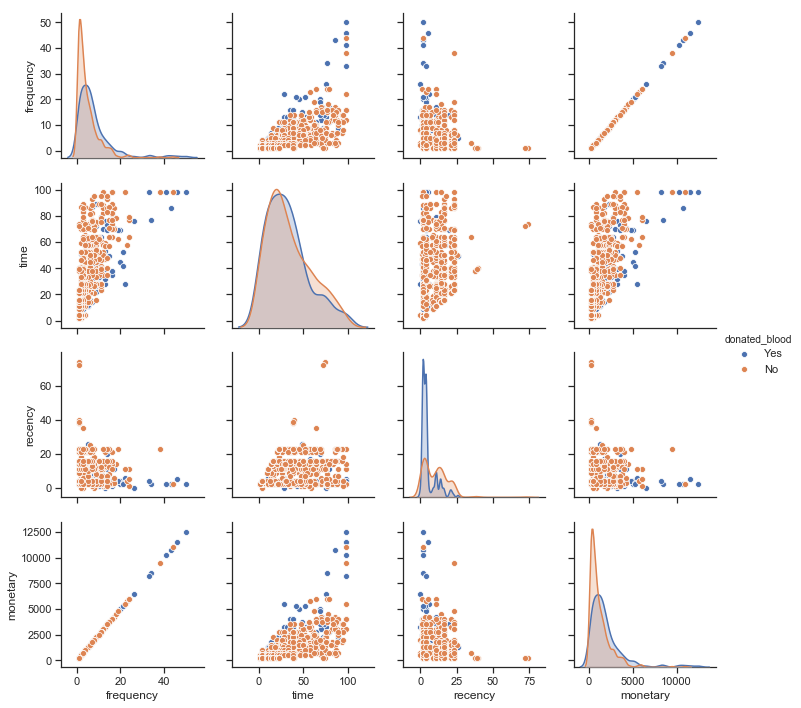

In [4]:
sns.set(style='ticks')
sns.pairplot(blood_data, hue='donated_blood', vars=['frequency', 'time', 'recency', 'monetary'])

In [16]:
y = blood_data["donated_blood"]
X = blood_data.drop(["donated_blood", "monetary"], axis=1)

There are a lot of duplicate values within the data causing noise

In [17]:
duplicates = X[X.duplicated()]
duplicates.sort_values(by=list(duplicates.columns)).head()

,recency,frequency,time
154,2,1,2
155,2,1,2
156,2,1,2
157,2,1,2
158,2,1,2


In [18]:
non_duplicates = y.index.difference(duplicates.index)
y = y.iloc[non_duplicates]
X = X.iloc[non_duplicates]

In [19]:
y.value_counts()

No     371
Yes    131
Name: donated_blood, dtype: int64

## Create Test and Training Sets

10% of the data was withheld and put into a test set. The remaining 90% was placed in the training set to be fed into our models. The entire dataset contains 748 samples including 570 positive samples (people who donated blood in March 2007) and 178 negative samples. As the classes are somewhat unbalanced, I decided to stratify the test train split.

In [6]:
y_train, y_test = train_test_split(y, test_size=0.1, stratify=y, random_state=42)
X_train, X_test = train_test_split(X, test_size=0.1, stratify=y, random_state=42)

## Functions

In [7]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding tfdrain/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        
    taken from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def plot_validation_curve(estimator, title, X, y, ylim=None, cv=None,
                          n_jobs=1, param_name=None, alternative_x_axis=None,
                          param_range=np.linspace(1, 100, 10)):
    
    x_axis = alternative_x_axis if alternative_x_axis is not None else param_range
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Parameter Setting")
    plt.ylabel("Score")
    train_scores, test_scores = validation_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, param_name=param_name, param_range=param_range)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(param_range, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(param_range, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


## Using a Decision Tree Classifier

The decision tree, like all the other models I trained for this paper, was taken from the scikit-learn package available for python. I began my analysis by performing a grid search over the hyperparameters max_depth and min_samples_split to see which produced the highest cross-validation score (10 folds).

The decision tree will not split the data more than max_depth-times down any individual branch. min_samples_split is the mininum number of samples needed in a node for it to be split into a new branch. Setting these parameters is equivalent to pre-pruning the tree. The values max_depth = 11 and min_samples_split = 40 appear to produce the highest cross-validation score, so we'll use those as a starting point.

In [8]:
parameters = {
    'max_depth' : list(range(1, 30, 2)),
    'min_samples_split' : list(range(20, 1000, 10))
}

decision_tree = DecisionTreeClassifier()
clf = GridSearchCV(decision_tree, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'max_depth': 3, 'min_samples_split': 140}

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

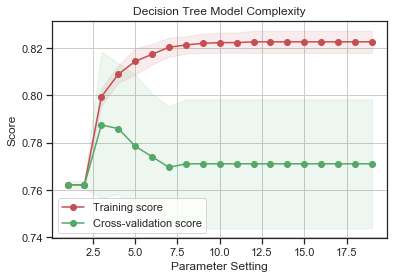

In [9]:
# built in validation curve
clf = DecisionTreeClassifier(min_samples_split=40)
plot_validation_curve(estimator=clf, title="Decision Tree Model Complexity",
                      X=X_train, y=y_train, param_name='max_depth',
                      param_range=range(1, 20), cv=10)

As the max_depth of the decision tree increases, the training score moves asymptotically towards about 82% accuracy. Meanwhile the cross-validation score peaks at 3 or 4 depth and then plummets until it reaches 8 depth. From there it flatlines at about 77% accuracy. From this graph it's apparent that the algorithm is able to construct trees that better fit the training data as max_depth grows, but those increasingly elaborate trees do not generalize well. Which is exactly what we expect to see.

A decision tree with a large enough depth should be able to fit any training data, so why does it asymptotically approach 83%? It turns out that about 30% of the dataset have features that are exactly the same, but some of these samples with identical features will have different classification. As such, there are "two versions of the truth" on a large percentage of the data, and it is likely impossible for any of our classifiers to break 83% accuracy on this dataset.

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

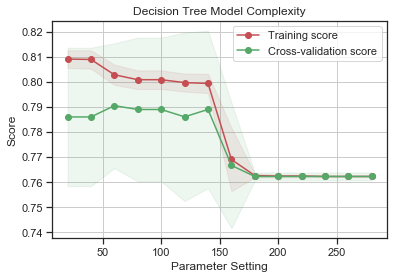

In [23]:
clf = DecisionTreeClassifier(max_depth=4)
plot_validation_curve(estimator=clf, title="Decision Tree Model Complexity",
                      X=X_train, y=y_train, param_name='min_samples_split',
                      param_range=range(20, 300, 20), cv=10)

The min_samples_split parameter on the other hand, seems to perform roughly the same for any setting below 150 samples, after which both training and cross-validation scores plummet. It seems the model needs the flexibility to split sample sets as small as 150 to properly fit the model.

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

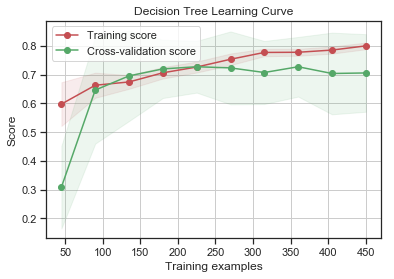

In [27]:
# the built in learning curve
clf = DecisionTreeClassifier(max_depth=9, min_samples_split=60)
plot_learning_curve(estimator=clf, title="Decision Tree Learning Curve", X=X, y=y, cv=10)

The learning curve for the decision tree shows both the training and cross-validation scores steadily increasing as more samples are made available. 

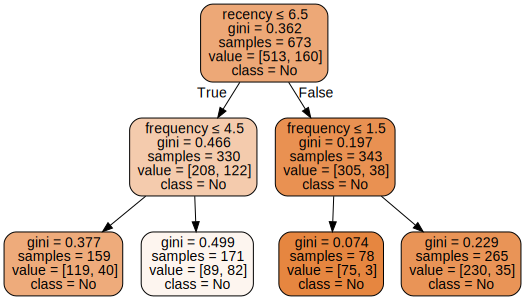

In [13]:
clf = DecisionTreeClassifier(max_depth=2, min_samples_split=40)
clf.fit(X_train, y_train)
dot_data = export_graphviz(clf, out_file=None,  
                         feature_names=X.columns,
                         class_names = ['No', 'Yes'],
                         filled=True, rounded=True,  
                         special_characters=True)  

graphviz.Source(dot_data)

In [14]:
clf.score(X_test, y_test)

0.76

## Using K Nearest Neighbors

In [15]:
parameters = {
    'n_neighbors' : list(range(1, 30)),
    'weights' : ['uniform', 'distance'],
    "p" : [1, 2]
}

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'n_neighbors': 16, 'p': 2, 'weights': 'uniform'}

A grid search reveals the optimum hyperparameters to be n_neighbors = 12, p = 1, and weights = 'distance'

On the car dataset, where all the features are binary classifiers, this algorithm will be looking for similarity in a way that weights all features exactly the same. Which may effect its accuracy

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

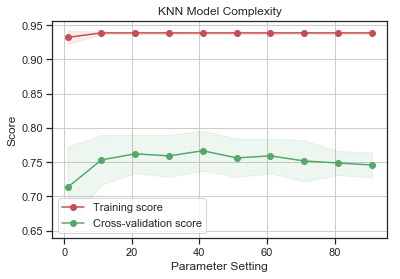

In [28]:
clf = KNeighborsClassifier(p=2, weights='distance')
plot_validation_curve(estimator=clf, title="KNN Model Complexity", X=X_train, y=y_train, param_name='n_neighbors',
                      param_range=range(1, 100, 10), cv=10)

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

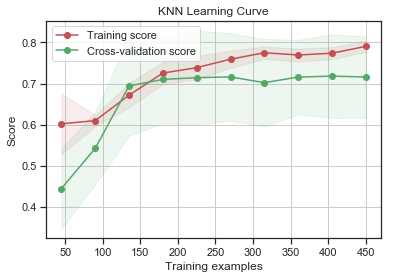

In [31]:
# the built in learning curve
clf = KNeighborsClassifier(p=2, n_neighbors=15)
plot_learning_curve(estimator=clf, title="KNN Learning Curve", X=X, y=y, cv=10)

In [34]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7866666666666666

## Using AdaBoost

In [ ]:
parameters = {
    'n_estimators' : list(range(20, 80)),
    'learning_rate' : [10**x for x in range(-1, 2)],
}

ada_booster = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4, min_samples_split=70))
clf = GridSearchCV(ada_booster, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

In [ ]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4, min_samples_split=40), learning_rate=1)
plot_validation_curve(estimator=clf, title="AdaBoost (Decision Tree) Model Complexity",
                      X=X_train, y=y_train, param_name='n_estimators', param_range=range(1, 100, 5), cv=10)

In [ ]:
# the built in learning curve
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4, min_samples_split=20), learning_rate=1, n_estimators=10)
plot_learning_curve(estimator=clf, title="AdaBoost Learning Curve", X=X, y=y, cv=10)

## Using a Neural Net

In [ ]:
parameters = {
    'hidden_layer_sizes' : [tuple([x] * n) for x in range(10,100,10) for n in range(1,5)],
    'max_iter' : range(200, 500, 100)
}

# 'max_iter' : range(200, 500, 50),

mlp = MLPClassifier()
clf = GridSearchCV(mlp, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

Best hidden layer size = 3 rows of 50 (50, 50, 50)
for the cars dataset = (70, 70, 70)

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(60, 60, 60, 60))
plot_validation_curve(estimator=clf, title="Test", X=X_train, y=y_train, param_name='max_iter',
                      param_range=range(100, 1000, 200), cv=10)

In [ ]:
# the built in learning curve
clf = MLPClassifier(hidden_layer_sizes=(60, 60, 60, 60), max_iter=700)
plot_learning_curve(estimator=clf,
                    title="Test", X=X, y=y, cv=10)

## Using a Support Vector Machine

In [ ]:
parameters = [{
    'C' : [1, 10, 100, 1000],
    'kernel' : ['poly'],
    'degree' : range(1,10)
},
{
    'C' : [1, 10, 100, 1000],
    'kernel' : ['rbf'],
    'gamma': [1e-3, 1e-4]
},
{
    'C' : [1, 10, 100, 1000],
    'kernel' : ['linear']
}
]

lsvc = SVC()
clf = GridSearchCV(lsvc, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

In [ ]:
poly = SVC(C=1000, kernel='poly', degree=2)
rbf = SVC(C=1000, gamma=0.001)
linear = LinearSVC(C=10)

for model in (poly, rbf, linear):
    model.fit(X=X_train, y=y_train)

In [ ]:
svm_scores = pd.DataFrame({
    "kernel" : ['polynomial', 'linear', 'rbf'],
    "training score" : [poly.score(X_train, y_train),
                        linear.score(X_train, y_train),
                        rbf.score(X_train, y_train)],
    "cross validation score" : [cross_val_score(poly, X=X_train, y=y_train, cv=10).mean(),
                                cross_val_score(linear, X=X_train, y=y_train, cv=10).mean(),
                                cross_val_score(rbf, X=X_train, y=y_train, cv=10).mean()]
})

In [ ]:
# the built in learning curve
clf = SVC(kernel='poly', degree=3, C=1000)
plot_learning_curve(estimator=clf, title="Test", X=X, y=y, cv=StratifiedShuffleSplit())

In [ ]:
clf = LinearSVC(C=10)
plot_learning_curve(estimator=clf, title="Test", X=X, y=y, cv=10)

In [ ]:
clf = SVC(kernel='poly', degree=3, C=1000)
plot_learning_curve(estimator=clf, title="Test", X=X, y=y, cv=10)